# Dynamo-scvelo benchmark

Here you will learn the basics of RNA velocity analysis.

For illustration, it is applied to endocrine development in the pancreas, with lineage commitment to four major fates: α, β, δ and ε-cells. <br/> 
See [here](https://scvelo.readthedocs.io/scvelo.datasets.pancreas.html) for more details. It can be applied to your own data along the same lines. 

The notebook is also available at
[Google Colab](https://colab.research.google.com/github/theislab/scvelo_notebooks/blob/master/VelocityBasics.ipynb)
and [nbviewer](https://nbviewer.jupyter.org/github/theislab/scvelo_notebooks/blob/master/VelocityBasics.ipynb).

In [1]:
# update to the latest version, if not done yet.
!pip install scvelo --upgrade --quiet

In [2]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.4 (python 3.8.12) on 2021-11-05 13:31.


In [3]:
import dynamo
import dynamo as dyn
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
from benchmark_utils import *
dyn_adata = dyn.sample_data.zebrafish()
print("original data shape:", dyn_adata.shape)

preprocessor = Preprocessor()
preprocessor.config_monocle_recipe(dyn_adata) # use monocle as default base config
preprocessor.config_seurat_recipe()
# preprocessor.preprocess_adata_seurat(dyn_adata)
dyn.preprocessing.utils.unique_var_obs_adata(dyn_adata)

scv.preprocessing.filter_genes(dyn_adata, min_shared_counts=20)
scv.preprocessing.utils.normalize_per_cell(dyn_adata)
# scv.preprocessing.filter_genes_dispersion(dyn_adata, n_top_genes=2000, flavor="seurat")
# scv.pp.log1p(dyn_adata)
# preprocessor.filter_genes_by_outliers(dyn_adata)
# preprocessor.normalize_by_cells(dyn_adata)
preprocessor.select_genes(dyn_adata, recipe="seurat", n_top_genes=2000)
preprocessor.log1p(dyn_adata)
preprocessor.pca(dyn_adata, pca_key="X_pca")

|-----> Downloading data to ./data/zebrafish.h5ad
|-----------> <insert> {} to uns['pp'] in AnnData Object.


original data shape: (4181, 16940)


|-----> filtering genes by dispersion...


Filtered out 11388 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


|-----> select genes by recipe: seurat
|-----------> choose 2000 top genes
|-----> <insert> pp_gene_means to var in AnnData Object.
|-----> <insert> gene_vars to var in AnnData Object.
|-----> <insert> gene_highly_variable to var in AnnData Object.
|-----> number of selected highly variable genes: 2000
|-----> [filter genes by dispersion] in progress: 100.0000%
|-----> [filter genes by dispersion] finished [0.5040s]
|-----> log1p transform applied to layers: ['X', 'spliced', 'unspliced']


AnnData object with n_obs × n_vars = 4181 × 5552
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'pp_gene_means', 'gene_vars', 'gene_highly_variable', 'use_for_pca'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced'

In [4]:
# dyn_adata.layers['spliced']
dyn_adata.layers["spliced"]

<4181x5552 sparse matrix of type '<class 'numpy.float32'>'
	with 3129565 stored elements in Compressed Sparse Row format>

In [5]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization


### Load the Data

The analysis is based on the in-built [pancreas data](https://scvelo.readthedocs.io/scvelo.datasets.pancreas).<br/>
To run velocity analysis on your own data, read your file (loom, h5ad, csv …) to an AnnData object with `adata = scv.read('path/file.loom', cache=True)`. If you want to merge your loom file into an already existing AnnData object, use `scv.utils.merge(adata, adata_loom)`.

In [6]:
adata = dynamo.sample_data.zebrafish()

|-----> Downloading data to ./data/zebrafish.h5ad


### Preprocess the Data by scelo

In [7]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, flavor="seurat")
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Filtered out 11388 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [8]:
dyn_adata

AnnData object with n_obs × n_vars = 4181 × 5552
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'pp_gene_means', 'gene_vars', 'gene_highly_variable', 'use_for_pca'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced'

In [9]:
adata

AnnData object with n_obs × n_vars = 4181 × 2000
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [10]:
print(adata.obsm["X_pca"].shape)
print(dyn_adata.obsm["X_pca"].shape)

(4181, 30)
(4181, 30)


## Comparison of X_pca, spliced and unspliced data  
Note: scvelo does not log1p transform unspliced and spliced layers/

scvelo seurat X_pca stats:
count    1.254300e+05
mean    -2.070514e-07
std      1.605636e+00
min     -8.343900e+00
25%     -6.412283e-01
50%     -2.956188e-02
75%      5.880693e-01
max      1.131858e+01
dtype: float64
dynamo seurat X_pca stats:


count    1.254300e+05
mean     2.721351e-07
std      1.605636e+00
min     -8.343904e+00
25%     -6.412333e-01
50%     -2.956304e-02
75%      5.880697e-01
max      1.131858e+01
dtype: float64

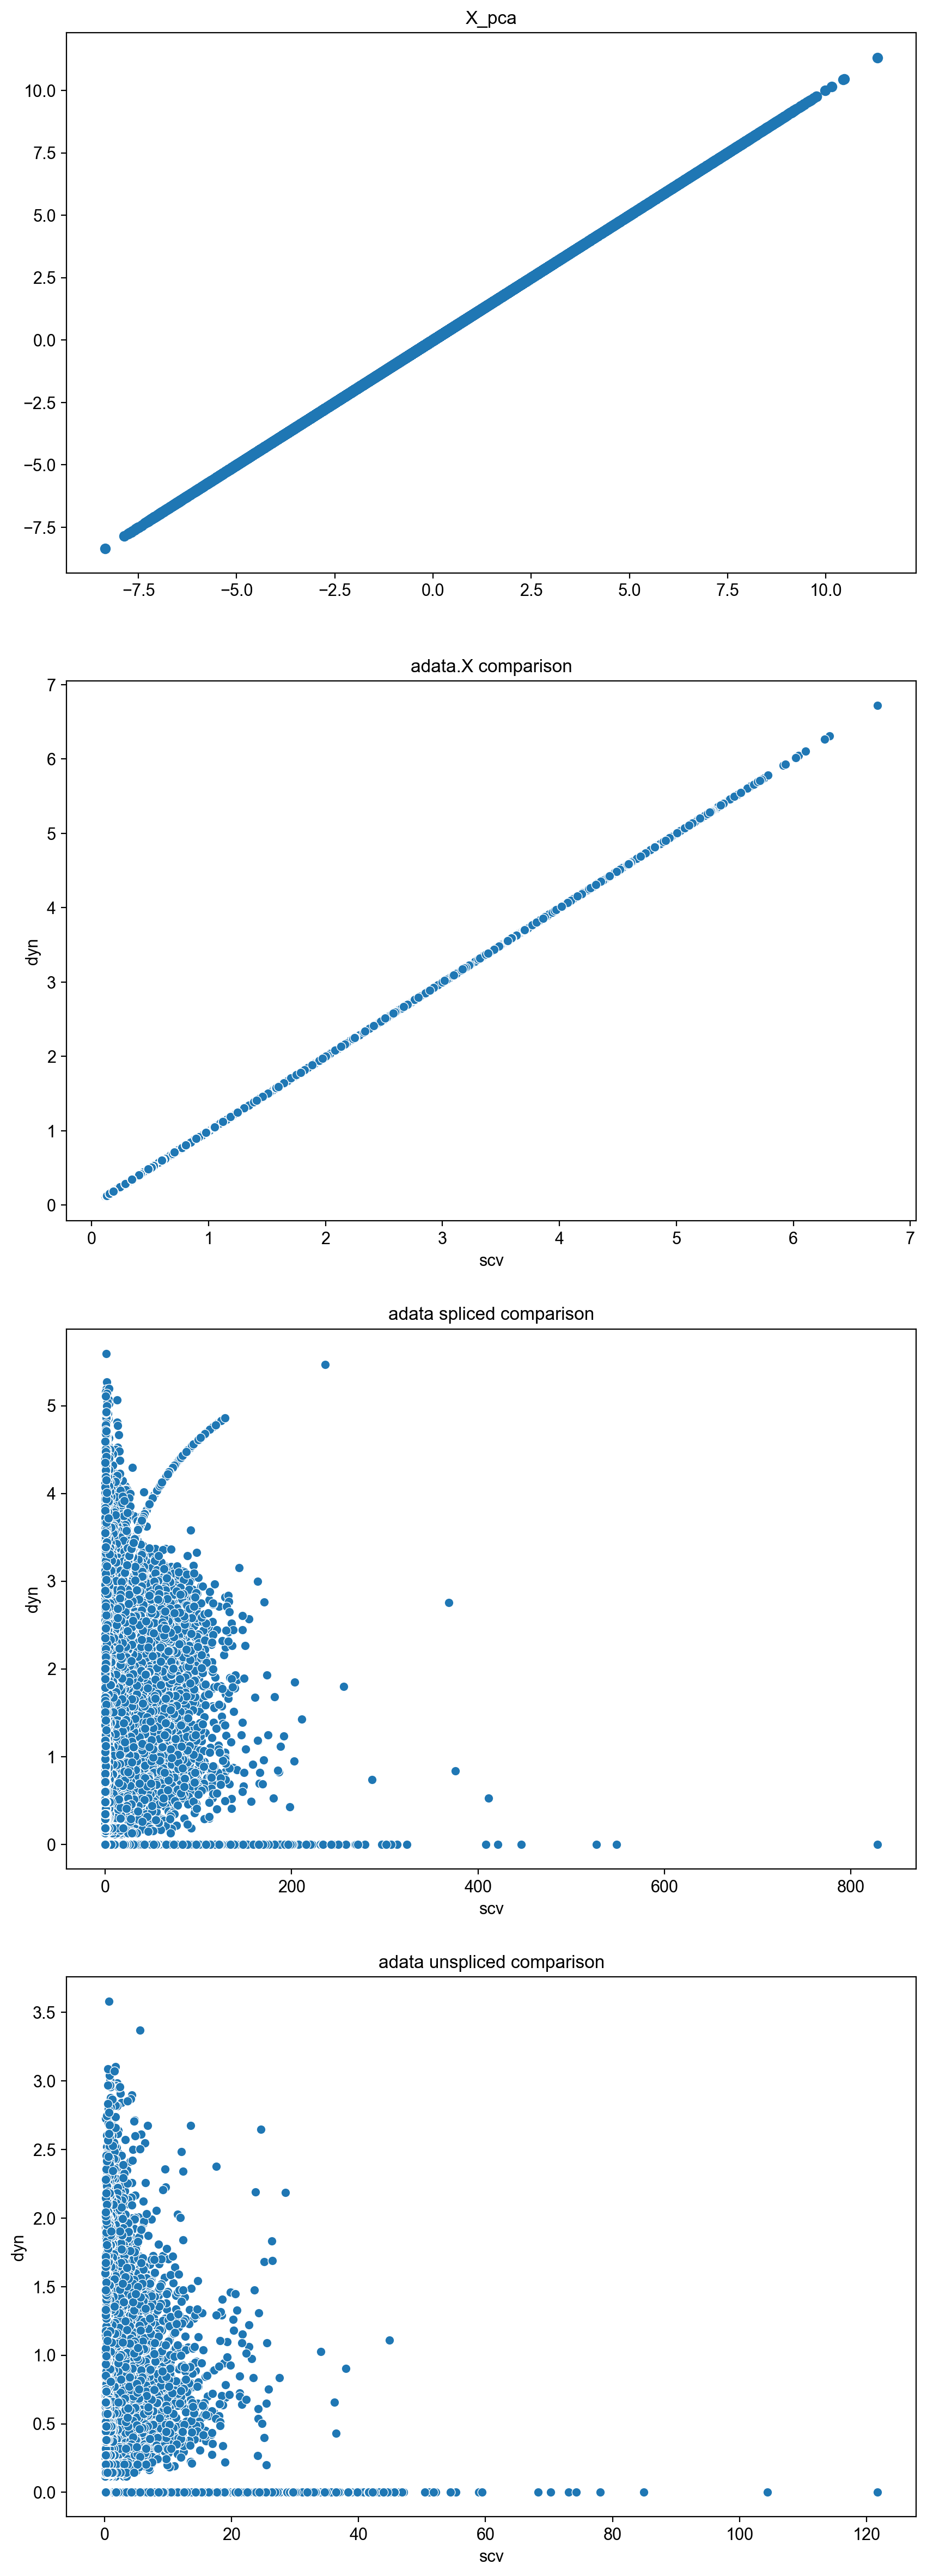

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
fig, axes = plt.subplots(4, figsize=(10, 30))

key = "X_pca"
axes[0].scatter(adata.obsm[key].flatten(), dyn_adata.obsm[key].flatten())#, title="X_pca comparison")
axes[0].set_title(key)
# plot_scatter_sparse(adata.layers["spliced"], dyn_adata.layers["spliced"], ax=axes[1])
# plot_scatter_sparse(adata.layers["unspliced"], dyn_adata.layers["unspliced"], ax=axes[2])
use_for_pca = dyn_adata.var[DKM.VAR_USE_FOR_PCA]
plot_scatter_sparse(adata.X, dyn_adata.X[:, use_for_pca], ax=axes[1])
axes[1].set_title("adata.X comparison")
axes[1].set_xlabel("scv")
axes[1].set_ylabel("dyn")

plot_scatter_sparse(adata.layers["spliced"], dyn_adata.layers["spliced"], ax=axes[2])
axes[2].set_title("adata spliced comparison")
axes[2].set_xlabel("scv")
axes[2].set_ylabel("dyn")
plot_scatter_sparse(adata.layers["unspliced"], dyn_adata.layers["unspliced"], ax=axes[3])
axes[3].set_title("adata unspliced comparison")
axes[3].set_xlabel("scv")
axes[3].set_ylabel("dyn")

print("scvelo seurat X_pca stats:")
print(pd.Series(adata.obsm["X_pca"].flatten()).describe())
print("dynamo seurat X_pca stats:")
pd.Series(dyn_adata.obsm["X_pca"].flatten()).describe()